Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [3]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** в целом, чем больше `batch_size` тем быстрее происходит обучение модели, так как за один раз она сможет просмотреть больше данных, но при достижении порога по оперативной памяти, увеличение этого параметра не будет приводить к ускорению обучения, а лишь ухудшит качетсво модели из-за переобучения

Посмотрим на какую-нибудь картинку:

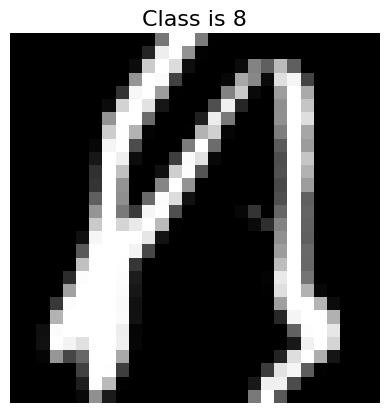

In [4]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





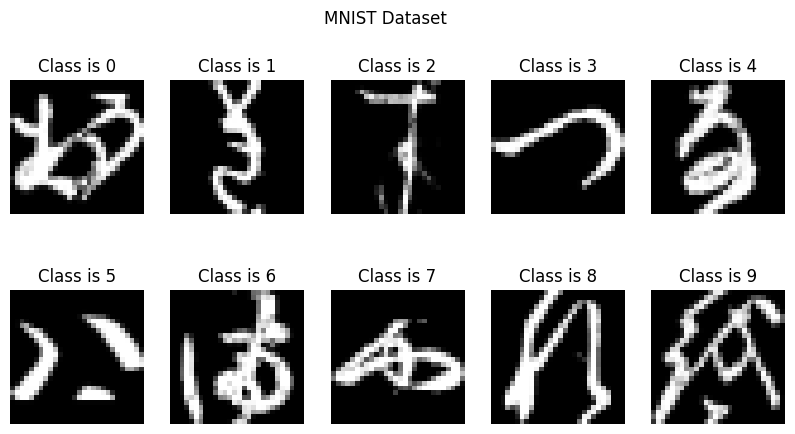

In [5]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
fig.suptitle('MNIST Dataset')

for i in range(10):
  k = 0
  while trainset[k][1] != i:
    k+=1
  axs[i//5][i%5].imshow(trainset[k][0].view(28, 28).numpy(), cmap="gray")
  axs[i//5][i%5].axis("off")
  axs[i//5][i%5].set_title(f"Class is {trainset[k][1]}", fontsize=12)

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        x = x.view(-1, 28*28)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        logits = self.fc3(x)

        return logits



```
# This is formatted as code
```

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:** Первый слой: (28*28*256+256) = 200960 весов+смещений, второй - 256*128 + 128 = 32896, третий - 128*10 + 10 = 1674. Таким образом - 203530 обучаемых параметра

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [7]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [8]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [9]:
%%time

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.9276
Epoch=2 loss=0.4496
Epoch=3 loss=0.3552
Epoch=4 loss=0.2961
Epoch=5 loss=0.2547
Epoch=6 loss=0.2207
Epoch=7 loss=0.1928
Epoch=8 loss=0.1688
Epoch=9 loss=0.1493
Epoch=10 loss=0.1312
CPU times: user 17 s, sys: 1.41 s, total: 18.4 s
Wall time: 1min 6s


In [10]:
get_accuracy(fc_net, testloader)

0.8749

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [ ]:
mean = ## calculate mean
std = ## calculate std
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

In [ ]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [ ]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE


In [ ]:
get_accuracy(fc_net, testloader)

Как изменилась `accuracy` после нормализации?

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [ ]:
## YOUR CODE HERE


In [ ]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE


In [ ]:
get_accuracy(fc_net, testloader)

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [ ]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x

        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.